In [76]:
!pip install geopandas

In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import sqlite3

sns.set_palette("Set2")
sns.set_style("ticks")

def create_connection(db_file, delete_db=False):
        import os
        if delete_db and os.path.exists(db_file):
            os.remove(db_file)
 
        conn = None
        try:
            conn = sqlite3.connect(db_file)
            conn.execute("PRAGMA foreign_keys = 1")
        except Error as e:
            print(e)
 
        return conn
 
def execute_sql_statement(sql_statement, conn):
        cur = conn.cursor()
        cur.execute(sql_statement)
 
        rows = cur.fetchall()
 
        return rows

## Random Forest Model

In [277]:
def model_query(conn):
    Sql_statement='''SELECT Neighborhood,CrimeTime,Count(C.CrimeID) as No_of_crimes
    FROM Crime C
    Join Person P on P.CrimeID=C.CrimeID
    Join Location L on L.LocationID=P.LocationID
    WHERE Neighborhood NOT IN ('')
    GROUP BY Neighborhood,CrimeTime
    ORDER BY Neighborhood,CrimeTime
    '''
    ### END SOLUTION
    df = pd.read_sql_query(Sql_statement, conn)
    return df

In [278]:
Risk_df=model_query(create_connection('normalizeddb9.db', delete_db=False))
print(Risk_df)

       Neighborhood  CrimeTime  No_of_crimes
0             ABELL          0            85
1             ABELL          1            74
2             ABELL          2            41
3             ABELL          3            37
4             ABELL          4            40
...             ...        ...           ...
6604  YORK-HOMELAND         19            13
6605  YORK-HOMELAND         20            13
6606  YORK-HOMELAND         21            11
6607  YORK-HOMELAND         22            14
6608  YORK-HOMELAND         23            21

[6609 rows x 3 columns]


In [280]:
risk_level=list()
Risk_df1 = Risk_df
crime_rate=list()
# print(Risk_df1['No_of_crimes'][2])
for i in range(len(Risk_df1['No_of_crimes'])):
     crime_rate.append(Risk_df1['No_of_crimes'][i])
crime_rate=sorted(crime_rate)
# print(len(Risk_df1['No_of_crimes']))
for i in range(len(Risk_df1['No_of_crimes'])):
    if Risk_df1['No_of_crimes'][i] <= crime_rate[int(len(crime_rate)/3)]:
        risk_level.append("LOW")
    elif Risk_df1['No_of_crimes'][i] < crime_rate[int(2*len(crime_rate)/3)] or Risk_df1['No_of_crimes'][i] < crime_rate[int(len(crime_rate)/3)]:
        risk_level.append("MEDIUM")
    elif Risk_df1['No_of_crimes'][i] >= crime_rate[int(2*len(crime_rate)/3)]:
        risk_level.append("HIGH")
Risk_df1["Risk_level"]=risk_level
print(Risk_df1)

       Neighborhood  CrimeTime  No_of_crimes Risk_level
0             ABELL          0            85       HIGH
1             ABELL          1            74     MEDIUM
2             ABELL          2            41     MEDIUM
3             ABELL          3            37     MEDIUM
4             ABELL          4            40     MEDIUM
...             ...        ...           ...        ...
6604  YORK-HOMELAND         19            13        LOW
6605  YORK-HOMELAND         20            13        LOW
6606  YORK-HOMELAND         21            11        LOW
6607  YORK-HOMELAND         22            14        LOW
6608  YORK-HOMELAND         23            21        LOW

[6609 rows x 4 columns]


In [282]:
# Dummy variables are useful because they enable us to use a single regression equation to represent multiple groups. This means that we don’t need to write out separate equation models for each subgroup. 
import pandas as pd


df_with_dummies= pd.get_dummies(Risk_df1,columns=["Neighborhood"],drop_first=False)
df_with_dummies


,CrimeTime,No_of_crimes,Risk_level,Neighborhood_ABELL,Neighborhood_ALLENDALE,Neighborhood_ARCADIA,Neighborhood_ARLINGTON,Neighborhood_ARMISTEAD GARDENS,Neighborhood_ASHBURTON,Neighborhood_BALTIMORE HIGHLANDS,...,Neighborhood_WINSTON-GOVANS,Neighborhood_WOODBERRY,Neighborhood_WOODBOURNE HEIGHTS,Neighborhood_WOODBOURNE-MCCABE,Neighborhood_WOODMERE,Neighborhood_WRENLANE,Neighborhood_WYMAN PARK,Neighborhood_WYNDHURST,Neighborhood_YALE HEIGHTS,Neighborhood_YORK-HOMELAND
0,0,85,HIGH,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,74,MEDIUM,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,41,MEDIUM,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,37,MEDIUM,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,40,MEDIUM,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6604,19,13,LOW,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6605,20,13,LOW,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6606,21,11,LOW,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6607,22,14,LOW,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [283]:
# Split dataset into features and target
y = df_with_dummies['Risk_level']
x = df_with_dummies.drop('Risk_level', axis=1)
X = x.drop('No_of_crimes', axis=1)

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

Random Forest is a powerful and versatile supervised machine learning algorithm that grows and combines multiple decision trees to create a “forest.” 

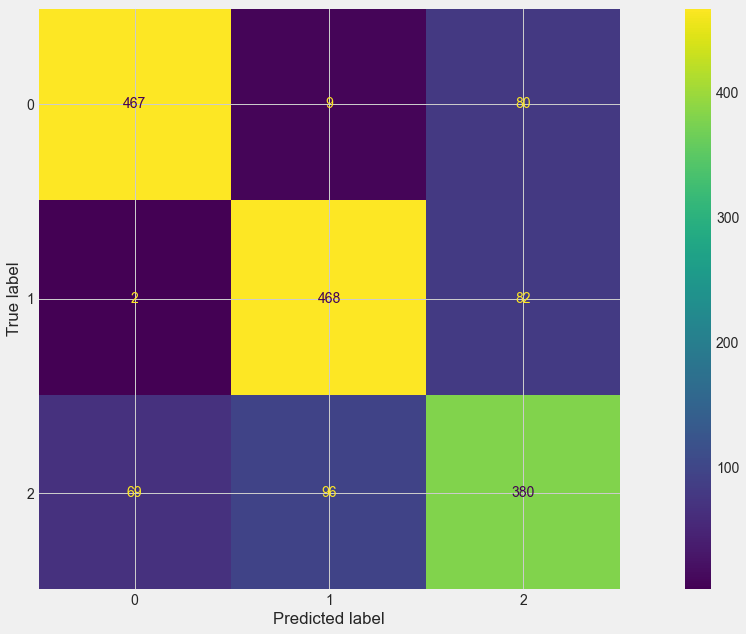

In [286]:
from sklearn.ensemble import RandomForestClassifier

# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, rfc_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()


In [287]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, rfc_predict)

0.7955232909860859